#Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [1]:
# Import Libraries

import os
import pickle
import pandas as pd
from helper_functions import calculate_results
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import random
import tensorflow_hub as hub

In [2]:
# Import cleaned Dataset

#clean_dir = '/content/Data/Cleaned_dataset/'
clean_dir = '/content/'

train_df = pd.read_csv(clean_dir + 'train.csv',index_col=False)
val_df = pd.read_csv(clean_dir + 'val.csv',index_col=False)
test_df = pd.read_csv(clean_dir + 'test.csv',index_col=False)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [3]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [4]:
# View first 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [5]:
# One hot encoding labels

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [6]:
# Extract labels ("target" columns) and encode them into integers

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [7]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))


In [8]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [9]:
# What's the average character length?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

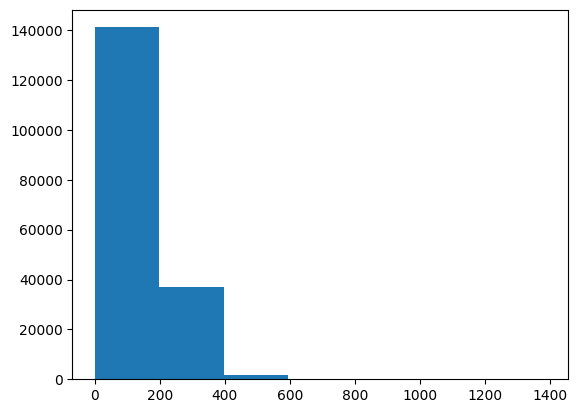

In [10]:
# Check the distribution of our sequences at character-level

import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [11]:
# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [12]:
# Get all keyboard characters for char-level embedding

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [14]:
# Check character vocabulary characteristics

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [15]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   n o n - r a n d o m i z e d   s e t   o f   @   p a t i e n t s   w e r e   a l s o   a d d e d   t o   t h e   c o n t r o l   g r o u p   (   m u l t i - c e n t e r   a n a l y s i s   )   .

Length of chars: 82

Vectorized chars:
[[ 5  6  7  6  8  5  6 10  7 15  4 25  2 10  9  2  3  7 17 14  5  3  4  2
   6  3  9 20  2  8  2  5 12  9  7  5 10 10  2 10  3  7  3 13  2 11  7  6
   3  8  7 12 18  8  7 16 14 15 16 12  3  4 11  2  6  3  2  8  5  6  5 12
  19  9  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

In [16]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   n o n - r a n d o m i z e d   s e t   o f   @   p a t i e n t s   w e r e   a l s o   a d d e d   t o   t h e   c o n t r o l   g r o u p   (   m u l t i - c e n t e r   a n a l y s i s   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.00648122  0.02905847 -0.02814831 ...  0.02079209 -0.02222271
   -0.01037711]
  [-0.02050116  0.0478842  -0.03223648 ... -0.03768954  0.02806376
   -0.02151967]
  [ 0.01267028 -0.01666323 -0.04450618 ...  0.041196    0.01585985
   -0.01552949]
  ...
  [ 0.04245938  0.03862799 -0.04157167 ... -0.04579286 -0.02532244
    0.00064635]
  [ 0.04245938  0.03862799 -0.04157167 ... -0.04579286 -0.02532244
    0.00064635]
  [ 0.04245938  0.03862799 -0.04157167 ... -0.04579286 -0.02532244
    0.00064635]]]

Character embedding shape: (1, 290, 25)


In [17]:
# Download pretrained TensorFlow Hub USE

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [18]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [21]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenating token and char inputs (create hybrid token embedding)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Creating output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
num_classes = 5
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constructing model with char and token inputs

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [22]:
# Get summary of token and character model

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

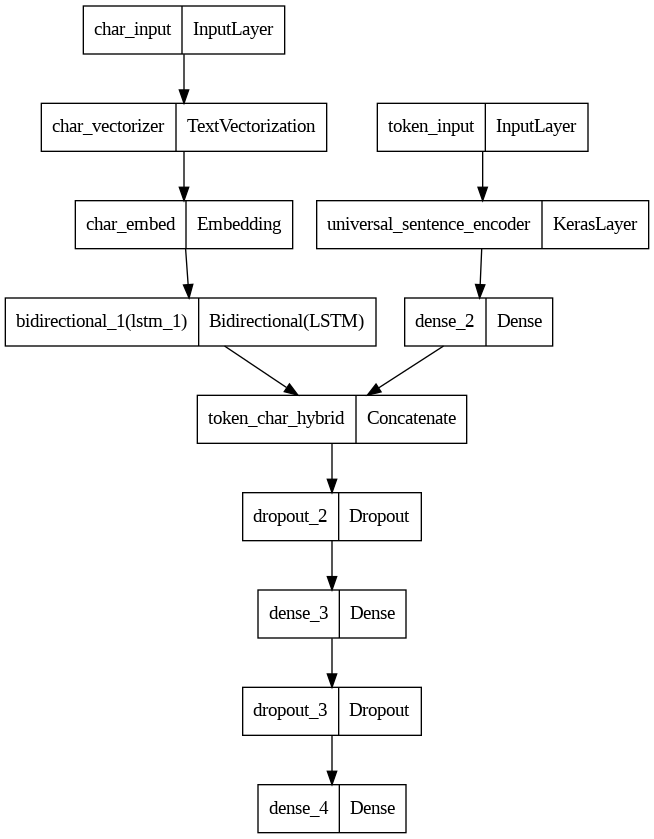

In [23]:
# Plotting hybrid token and character model

from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [24]:
# Compile token char model

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [25]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 41ms/step - loss: 0.9679 - accuracy: 0.6138 - val_loss: 0.7731 - val_accuracy: 0.7031
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7944 - accuracy: 0.6950 - val_loss: 0.7163 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7753 - accuracy: 0.7036 - val_loss: 0.6948 - val_accuracy: 0.7407


In [26]:
# Evaluate on the whole validation dataset

model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6990 - accuracy: 0.7358


[0.6990364193916321, 0.735833466053009]

In [27]:
# Make predictions using the token-character model hybrid

model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 23ms/step


array([[3.80232960e-01, 4.30409402e-01, 2.74398807e-03, 1.80969507e-01,
        5.64419245e-03],
       [3.88330638e-01, 4.48572397e-01, 1.99158932e-03, 1.59304336e-01,
        1.80115644e-03],
       [3.09016496e-01, 1.19757518e-01, 3.74840945e-02, 4.95676100e-01,
        3.80658433e-02],
       ...,
       [1.14789384e-03, 9.17667616e-03, 8.92988592e-02, 4.03313461e-04,
        8.99973333e-01],
       [1.04371505e-02, 6.31613135e-02, 2.60039508e-01, 4.87274118e-03,
        6.61489308e-01],
       [3.35080296e-01, 3.58234018e-01, 2.34303921e-01, 3.52133214e-02,
        3.71684358e-02]], dtype=float32)

In [28]:
# Turn prediction probabilities into prediction classes

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [29]:
# Get results of token-char-hybrid model

model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.5833443664769,
 'precision': 0.7359843415813945,
 'recall': 0.735833443664769,
 'f1': 0.7335879289465698}

<Axes: >

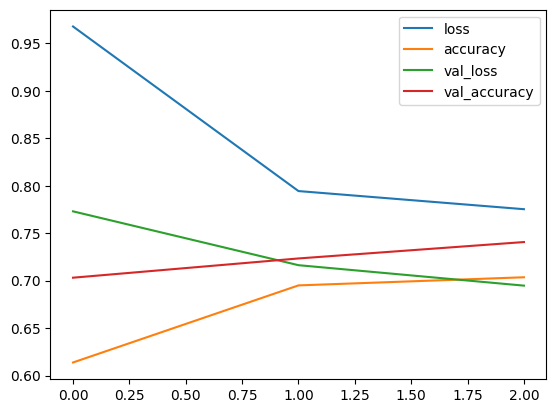

In [30]:
pd.DataFrame(model_4_history.history).plot()

In [31]:
# Export results for later comparison

with open('/content/model_4_results.pickle', 'wb') as f:
    pickle.dump(model_4_results, f)